*Reference*
- Raschka, S. (2015). Python Machine Learning. Packt Publishing.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('IMDb_train.csv')

In [3]:
df.shape

(25000, 2)

In [5]:
df.head()

,review,sentiment
0,Bromwell High is a cartoon comedy. It ran at t...,1
1,Homelessness (or Houselessness as George Carli...,1
2,Brilliant over-acting by Lesley Ann Warren. Be...,1
3,This is easily the most underrated film inn th...,1
4,This is not the typical Mel Brooks film. It wa...,1


In [8]:
import re
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords

def test(s):
    # remove html tag
    pattern = r'\<[^>]*\>'
    s = re.sub(pattern, '', s.lower())
    
    porter = PorterStemmer()
    stop = stopwords.words('english')
    
    words = [porter.stem(word) for word in s.split(' ') if word not in stop and word != '']
    
    return words
    
s = 'My name is <br/> Sam<br>'
s2 = 'Your job title is Software Engineer'
print(test(s))
print(test(s2))

['name', 'sam']
['job', 'titl', 'softwar', 'engin']


In [14]:
import re
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords

def preprocessor(s): 
    # remove html tag
    pattern = r'\<[^>]*\>'
    s = re.sub(pattern, '', s.lower())
    return s
    
def tokenizer_porter(s):
    porter = PorterStemmer()
    stop = stopwords.words('english')
    
    words = [porter.stem(word) for word in s.split(' ') if word not in stop and word != '']
    return words

s = 'runners like running<br> and thus they run'

countv = CountVectorizer()

tfidf = TfidfVectorizer()

tfidf2 = TfidfVectorizer(preprocessor=preprocessor,
        tokenizer=tokenizer_porter)

print(countv.fit_transform([s]).toarray())
print(countv.vocabulary_)
print(tfidf.fit_transform([s]).toarray())
print(tfidf.vocabulary_)
print(tfidf2.fit_transform([s]).toarray())
print(tfidf2.vocabulary_)

[[1 1 1 1 1 1 1 1]]
{'they': 6, 'and': 0, 'run': 3, 'runners': 4, 'br': 1, 'thus': 7, 'running': 5, 'like': 2}
[[ 0.35355339  0.35355339  0.35355339  0.35355339  0.35355339  0.35355339
   0.35355339  0.35355339]]
{'they': 6, 'and': 0, 'run': 3, 'runners': 4, 'br': 1, 'thus': 7, 'running': 5, 'like': 2}
[[ 0.37796447  0.75592895  0.37796447  0.37796447]]
{'thu': 3, 'runner': 2, 'run': 1, 'like': 0}


# 1. tf-idf and logistic regression

## memory overflow: use only 5000 data

In [15]:
df2 = df.sample(5000, random_state=0)

In [16]:
cnt = df2.sentiment.value_counts()
cnt_p = cnt/cnt.sum()*100
cnt_p

0    50.08
1    49.92
Name: sentiment, dtype: float64

In [17]:
docs = df2.review

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

tfidf = TfidfVectorizer(preprocessor=preprocessor,
        tokenizer=tokenizer_porter)

X = tfidf.fit_transform(docs).toarray()

In [19]:
y = df2.sentiment

In [20]:
X.shape

(5000, 83128)

In [21]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=0)

In [22]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(penalty='l2', C=1)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [23]:
print('train accuracy: %.2f %%' %(clf.score(X_train, y_train)*100))
print('test accuracy: %.2f %%' %(clf.score(X_test, y_test)*100))

train accuracy: 96.77 %
test accuracy: 83.40 %


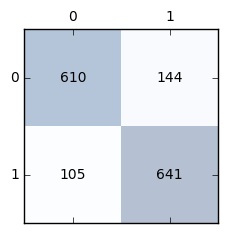

             precision    recall  f1-score   support

          0       0.85      0.81      0.83       754
          1       0.82      0.86      0.84       746

avg / total       0.83      0.83      0.83      1500



In [24]:
from sklearn.metrics import confusion_matrix, classification_report

mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(2.5,2.5))
ax.matshow(mat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(2):
    for j in range(2):
        ax.text(x=j,y=i,s=mat[i,j], ha='center', va='center')
plt.show()
print(classification_report(y_test, y_pred))

# 2. Online algorithm using stochastic gradient descent

In [25]:
def generate_doc(path):
    with open(path, 'r', encoding='utf-8') as f:
        next(f)
        for line in f:
            text, label = line[:-3], int(line[-2])
            yield text,label
            
def get_minibatch(gen_doc, size):
    text_list = []
    label_list = []
    cnt = 0
    for text, label in gen_doc:
        text_list.append(text)
        label_list.append(label)
        
        cnt += 1
        if cnt >= size:
            break
        
    return text_list, label_list

In [27]:
from sklearn.feature_extraction.text import HashingVectorizer

vect = HashingVectorizer(decode_error='ignore', 
                         n_features=2**21, 
                         preprocessor=preprocessor, 
                         tokenizer=tokenizer_porter)

In [ ]:
from sklearn.linear_model import SGDClassifier

clf = SGDClassifier(loss='log', random_state=0, n_iter=1)

In [28]:
gen_doc = generate_doc('IMDb_train.csv')

In [29]:
import pyprind
n = 20
pbar = pyprind.ProgBar(n)
train_acc = []
for _ in range(n):
    X_train, y_train = get_minibatch(gen_doc, size=1000)
    if not X_train:
        break
        
    X_train = vect.transform(X_train)
    clf.partial_fit(X_train, y_train, classes=np.array([0,1]))
    
    train_acc.append(clf.score(X_train, y_train)*100)
    
    pbar.update()

0%                100%
[####################] | ETA: 00:00:00
Total time elapsed: 00:00:47


In [30]:
train_acc

[100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 87.400000000000006,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0]

In [31]:
X_test, y_test = get_minibatch(gen_doc, size=5000)
X_test = vect.transform(X_test)
y_pred = clf.predict(X_test)

In [33]:
from sklearn.metrics import accuracy_score

print('test accuracy: %.5f' %(accuracy_score(y_test, y_pred)))

test accuracy: 1.00000
